In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Калибровка камеры по одному кадру.

ЗАДАНИЕ: по заданным парам точек $x_i$ на изображении и $X_i$ в пространстве
необходимо найти оценку матрицы перспективной камеры $\mathbf{M}$,
т.е. решить PnP задачу (см лекцию 1).

Алгоритм должен включать следующие этапы:
1. Инициализация матрицы камеры $\mathbf{M}$ методом DLT, БЕЗ Ransac.
2. Уточнение матрицы камеры $\mathbf{M}$ методом градиентной оптимизации
ошибки репроекции вида:
$$\mathcal{L}(x_i, X_i) = \sum\| \mathbf{M}X_i - x_i \|^2$$
3. Факторизация матрицы $\mathbf{M}$ на внешние и внутренние параметры.

In [ ]:
%%bash
if [ ! -d assets/ ]; then
    curl -sO 'https://code.mipt.ru/courses-public/cv/storage/-/raw/tasks/camera-calibration/assets.zip'
    unzip -qo assets.zip
fi

In [ ]:
image_path = 'assets/image.jpg'
corners_path = 'assets/corners.txt'
coords_path = 'assets/coords.txt'

(1280, 960, 3)

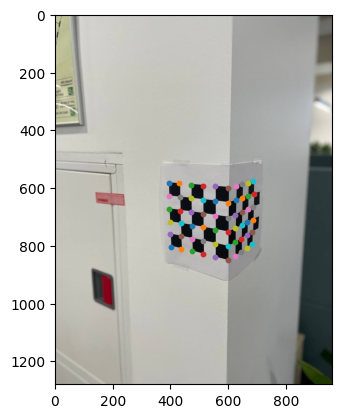

In [ ]:
x3d = np.loadtxt(coords_path)
x2d = np.loadtxt(corners_path)

img = cv2.imread(image_path)
h, w, _ = img.shape
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
for x in x2d:
    plt.scatter(*x, s=10)

img.shape

Ожидаемый результат:<br/><img src="https://code.mipt.ru/courses-public/cv/storage/-/raw/tasks/camera-calibration/image1.png" style="display:inline-block"/>

In [ ]:
def to_homo(x):
    return np.concatenate([x, np.ones(x.shape[0])[..., None]], axis=1)

def to_cartesian(x):
    return (x / x[..., -1:])[..., :-1]

def geometric_distance(x, y):
    return np.sum((x-y)**2)

## Шаг 1. DLT инициализация матрицы камеры
Линейная оценка матрицы камеры может быть получена из решения линейного уравнения вида (см лекция 1):
$$\Large A \cdot \vec{m}^T = 0$$

In [ ]:
def build_system(x3d, x2d):
    # input: x3d - world points
    #        x2d - pixel coords
    # ouptut: A - [2n, 12] matrix

    A = np.zeros((2*x3d.shape[0], 12))
    _pointer = 0

    for coords_3d, coords_2d in zip(x3d, x2d):
        X, Y, Z, _ = coords_3d
        x, y, _ = coords_2d
        A[_pointer:_pointer + 2,:] = np.array((
            [X, Y, Z, 1, 0, 0, 0, 0, -x*X, -x*Y, -x*Z, -x],
            [0, 0, 0, 0, X, Y, Z, 1, -y*X, -y*Y, -y*Z, -y]
        ))
        _pointer += 2

    return A

def solve_system(A):
    # input: A - matrix
    # output: solution for Am = 0
    U, S, V = np.linalg.svd(A)
    return V[-1]


In [ ]:
A = build_system(to_homo(x3d), to_homo(x2d))
M = solve_system(A).reshape(3,4)
print(M)

[[ 4.64056777e-02 -2.68687576e-02 -5.72632285e-03  5.74502367e-01]
 [ 1.70939202e-02  1.28637769e-02 -5.43123524e-02  8.14635127e-01]
 [ 3.86536983e-05  2.73517398e-05 -1.02414316e-05  9.58743955e-04]]


Parameters:

[[ 4.64056777e-02, -2.68687576e-02, -5.72632285e-03,  5.74502367e-01] \
 [ 1.70939202e-02,  1.28637769e-02, -5.43123524e-02,  8.14635127e-01] \
 [ 3.86536983e-05,  2.73517398e-05, -1.02414316e-05,  9.58743955e-04]]

`cross-check:0` (5 баллов)

In [ ]:
coarse = geometric_distance(x2d, to_cartesian((M@to_homo(x3d).T).T))
assert coarse < 50

### Шаг 2. Уточнение матрицы градиентным методом

Для уточнения матрицы $\mathbf{M}$ используем градиентный метод оптимизации: Levenberg-Marquardt algorithm.
Рекомендуется использовать его имплементацию из пакета scipy.

** попробуйте разные виды остатков

In [ ]:
from scipy.optimize import least_squares

def reprojection_error(M, x2d, x3d):
  """
  M - flatten matrix
  x2d - pixel coords
  x3d - world coords
  """
  return geometric_distance(x2d, to_cartesian((M.reshape(3, 4) @ to_homo(x3d).T).T))

def refine(DLT_M):
    # input: DLT_xM - coarse estimate
    # (optional) x2d, x3d
    # output: refined solution for M

    DLT_M_copy = DLT_M.copy()
    res = least_squares(reprojection_error, DLT_M_copy.flatten(), args=(x2d, x3d))
    DLT_M_refined = res.x.reshape(3,4)
    return DLT_M_refined

In [ ]:
M = refine(M)
print(M)

[[ 4.64056777e-02 -2.68687576e-02 -5.72632285e-03  5.74502367e-01]
 [ 1.70939202e-02  1.28637769e-02 -5.43123524e-02  8.14635127e-01]
 [ 3.86495159e-05  2.73491616e-05 -1.02358976e-05  9.58743338e-04]]


Refined matrix (same as matrix calculated using DLT method):

[[ 4.64056777e-02, -2.68687576e-02, -5.72632285e-03,  5.74502367e-01] \
 [ 1.70939202e-02,  1.28637769e-02, -5.43123524e-02,  8.14635127e-01] \
 [ 3.86495159e-05,  2.73491616e-05, -1.02358976e-05,  9.58743338e-04]]

`cross-check:1` (2 балла)

In [ ]:
fine = geometric_distance(x2d, to_cartesian((M@to_homo(x3d).T).T))
assert fine < coarse

### Шаг 3. Факторизация матрицы камеры
На этом этапе необходимо получить внешиние и внутренние параметры камеры вида:
$$\mathbf{M} = \mathbf{K} \big[\mathbf{R} | \mathbf{t}\big]$$

$\mathbf{K}$ - верхнетреугольная матрица с положительными числами

$\mathbf{R}$ - ортогональная матрица с положительным детерминантом

$t$ - вектор из трех чисел

In [ ]:
import numpy as np
from scipy.linalg import rq

def get_camera_center(M):
    _, _, Vt = np.linalg.svd(M)
    C = Vt[-1]
    return C[:3] / C[3]


def factorize(M):
    # input: M
    # output: K, R, t

    C = get_camera_center(M)
    K, R = rq(M[:, :3])   # where Q is unitary/orthogonal and R upper triangular
    T = np.diag(np.sign(np.diag(K)))
    K = K @ T
    R = T @ R
    K /= K[2,2]

    return K, R, C


In [ ]:
K, R, t = factorize(M)
print(f"{K = }")
print(f"{R = }")
print(f"{t = }")

K = array([[1.00628336e+03, 5.01837072e+00, 4.76162890e+02],
       [0.00000000e+00, 1.00269074e+03, 6.68398605e+02],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])
R = array([[ 0.57535561, -0.81780613, -0.0126121 ],
       [-0.17992818, -0.11151347, -0.97733853],
       [ 0.79786701,  0.56458647, -0.21130627]])
t = array([-16.5298145 ,  -8.81038363,   7.70986652])


`cross-check:2` (3 балла)

In [ ]:
assert np.isclose(K[2,2], 1)
assert np.isclose(np.linalg.det(R), 1)
assert np.abs(K[0,2] - 960 / 2) < 30
assert np.abs(K[1,2] - 1280 / 2) < 30
assert (K[0, 0] > 1000) & (K[1, 1] > 1000)

In [ ]:
def make_grid(M):
    x3d = [[0, i, k] for i in range(10) for k in range(-5, 10)] + [[i, 0, k] for i in range(10) for k in range(-5, 10)]
    x3d = np.array(x3d)

    x2d = to_cartesian((M@to_homo(x3d).T).T)

    plt.subplots(figsize=(10, 10))
    plt.imshow(img)
    plt.scatter(x2d[..., 0], x2d[..., 1], s=20, color='green', marker='x')

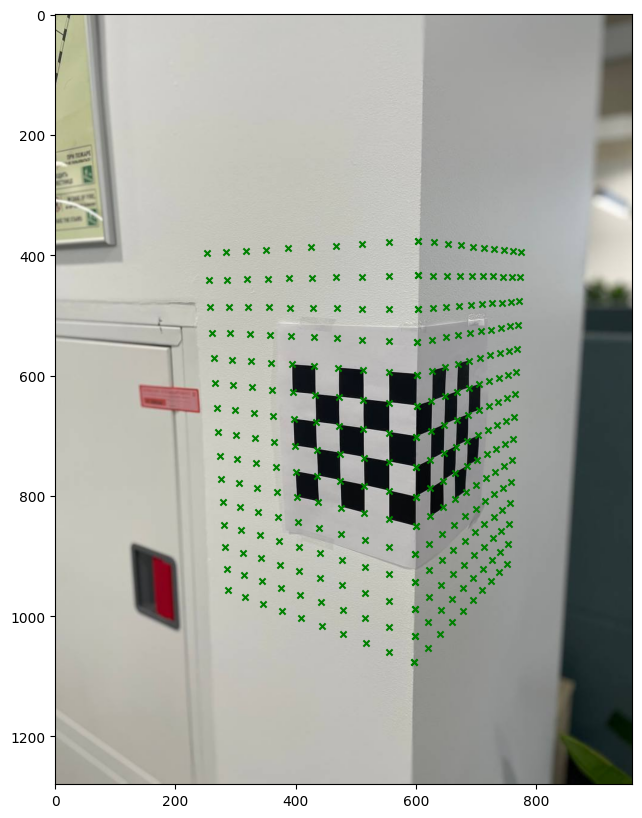

In [ ]:
make_grid(M)

Ожидаемый результат:<br/><img src="https://code.mipt.ru/courses-public/cv/storage/-/raw/tasks/camera-calibration/image2.png" style="display:inline-block"/>